# Test

## 0. imports

In [1]:
%load_ext jupyter_black

In [2]:
import sys

sys.path.append("..")

In [39]:
import os
import glob

import omegaconf
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.auto import tqdm, trange

In [35]:
import matplotlib.pyplot as plt

In [4]:
from src.dataset import ETTDataModule
from src.model import Transformer
from src.module import Trainer
from src.module.utils import fix_seed

## 1. dm

In [5]:
config_path = "./transformer_config.yaml"
config = omegaconf.OmegaConf.load(config_path)

In [6]:
dm = ETTDataModule(**config.dm)

## 2. model

In [7]:
model = Transformer(**config.model)

## 3. Train

In [8]:
fix_seed(config.train.seed)

trainer = Trainer(config=config, model=model, dm=dm)

In [9]:
version = trainer.fit()

epoch:   0%|          | 0/20 [00:00<?, ?it/s]

train_steps:   0%|          | 0/264 [00:00<?, ?it/s]

valid_steps:   0%|          | 0/87 [00:00<?, ?it/s]

train_steps:   0%|          | 0/264 [00:00<?, ?it/s]

valid_steps:   0%|          | 0/87 [00:00<?, ?it/s]

train_steps:   0%|          | 0/264 [00:00<?, ?it/s]

valid_steps:   0%|          | 0/87 [00:00<?, ?it/s]

train_steps:   0%|          | 0/264 [00:00<?, ?it/s]

valid_steps:   0%|          | 0/87 [00:00<?, ?it/s]

## 4. Test

### 4.1 load trained model

In [9]:
def load_trained_model(config, device: str):
    version = config.version
    dataset_name = config.dm.dataset_name
    task_name = config.model.task_name

    ckpt_list = glob.glob(
        os.path.join(
            config.train.ckpt_dir,
            f"version-{version}-{task_name}-{dataset_name.lower()}/*.pt",
        )
    )
    ckpt_list = sorted(ckpt_list, key=lambda e: e.split("_")[-1], reverse=True)

    state_dict = torch.load(ckpt_list[-1])
    model = Transformer(**config.model)
    model.load_state_dict(state_dict)
    model = model.to(device)

    return model

In [10]:
config.version = version
device = "cuda" if torch.cuda.is_available() else "cpu"

model = load_trained_model(config, device)

### 4.2 test

In [34]:
pred_len = config.dm.pred_len
label_len = config.dm.label_len
task_type = config.dm.task_type

inputs = []
predicts, targets = [], []
model.eval()
with torch.no_grad():
    for batch in tqdm(dm.test_dataloader(), total=len(dm.test_dataloader())):
        batch = {k: v.to(device) for k, v in batch.items()}

        # decoder input
        dec_inp = torch.zeros_like(batch["future_values"][:, -pred_len:, :]).float()
        dec_inp = torch.cat(
            [batch["future_values"][:, :label_len, :], dec_inp], dim=1
        ).float()

        output = model(
            past_values=batch["past_values"],
            past_time_features=batch["past_time_features"],
            future_values=dec_inp.to(device),
            future_time_features=batch["future_time_features"],
        )
        output = output["last_hidden_states"]

        f_dim = -1 if task_type == "MS" else 0
        predict = output[:, -pred_len:, f_dim:]
        target = batch["future_values"][:, -pred_len:, f_dim:]

        predict = predict.cpu().numpy()
        target = target.cpu().numpy()

        past_values = batch["past_values"]
        past_values = past_values.cpu().numpy()

        if dm.scaler is not None:
            shape = predict.shape
            predict = dm.scaler.inverse_transform(predict.squeeze(0)).reshape(shape)
            target = dm.scaler.inverse_transform(target.squeeze(0)).reshape(shape)
            past_values = dm.scaler.inverse_transform(past_values.squeeze(0)).reshape(
                shape
            )

        predict = predict[:, :, f_dim:]
        target = target[:, :, f_dim:]

        inputs.append(past_values)
        predicts.append(predict)
        targets.append(target)

  0%|          | 0/2785 [00:00<?, ?it/s]

In [42]:
idx = np.random.choice(range(len(inputs)), 1).item()

In [47]:
gt = np.concatenate((inputs[idx][0, :, f_dim], targets[idx][0, :, f_dim]), axis=0)
pr = np.concatenate((inputs[idx][0, :, f_dim], predicts[idx][0, :, f_dim]), axis=0)

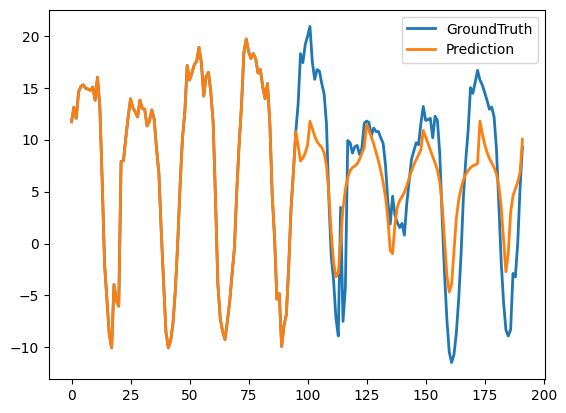

In [55]:
plt.figure()
plt.plot(gt, label="GroundTruth", linewidth=2)
if pr is not None:
    plt.plot(pr, label="Prediction", linewidth=2)
plt.legend()
plt.show()